# Proyecto: Big Data Processing



### 1. Unión de tablas con las columnas específicas con las que trabajaremos

En esta parte solo importamos las dos tablas con las que trabajamos y las unimos para crear un DataFrame llamado "data" con el que estaremos trabajando a lo largo de la practica. esto debido a que las tablas no tenian el mismo numero de columnas.

In [2]:
import pyspark as ps

#Creamos una sesion de spark
from pyspark.sql import SparkSession
from pyspark.sql.functions import col


#Creamos un objeto de spark session
spark = SparkSession.builder.appName("pysparkdf").getOrCreate()

In [3]:
reporte_1 = r"C:\Users\rober\OneDrive\Desktop\Bootcamp\Big Data e IA bootcamp\Data Processing\Proyecto Final\world-happiness-report.csv"
reporte_2 = r"C:\Users\rober\OneDrive\Desktop\Bootcamp\Big Data e IA bootcamp\Data Processing\Proyecto Final\world-happiness-report-2021.csv"

df1 = spark.read.option("header", "true").csv(reporte_1)
reporte2 = spark.read.option("header", "true").csv(reporte_2)

In [4]:
print("Schema of df1:")
df1.printSchema()

Schema of df1:
root
 |-- Country name: string (nullable = true)
 |-- year: string (nullable = true)
 |-- Life Ladder: string (nullable = true)
 |-- Log GDP per capita: string (nullable = true)
 |-- Social support: string (nullable = true)
 |-- Healthy life expectancy at birth: string (nullable = true)
 |-- Freedom to make life choices: string (nullable = true)
 |-- Generosity: string (nullable = true)
 |-- Perceptions of corruption: string (nullable = true)
 |-- Positive affect: string (nullable = true)
 |-- Negative affect: string (nullable = true)



In [5]:
print("Schema of df2:")
reporte2.printSchema()

Schema of df2:
root
 |-- Country name: string (nullable = true)
 |-- Regional indicator: string (nullable = true)
 |-- Ladder score: string (nullable = true)
 |-- Standard error of ladder score: string (nullable = true)
 |-- upperwhisker: string (nullable = true)
 |-- lowerwhisker: string (nullable = true)
 |-- Logged GDP per capita: string (nullable = true)
 |-- Social support: string (nullable = true)
 |-- Healthy life expectancy: string (nullable = true)
 |-- Freedom to make life choices: string (nullable = true)
 |-- Generosity: string (nullable = true)
 |-- Perceptions of corruption: string (nullable = true)
 |-- Ladder score in Dystopia: string (nullable = true)
 |-- Explained by: Log GDP per capita: string (nullable = true)
 |-- Explained by: Social support: string (nullable = true)
 |-- Explained by: Healthy life expectancy: string (nullable = true)
 |-- Explained by: Freedom to make life choices: string (nullable = true)
 |-- Explained by: Generosity: string (nullable = true)


In [6]:
# Agregamos la columna year a nuestro df2 ya que no contaba el

from pyspark.sql.functions import lit

df2 = reporte2.withColumn("year", lit(2021))




In [7]:
# Seleccionar las columnas específicas de df1
columns_df1 = ["Country name", "year", "Life Ladder", "Log GDP per capita", "Healthy life expectancy at birth"]
new_df1 = df1.select(columns_df1)

# Seleccionar las columnas específicas de df2, incluyendo "Regional indicator"
columns_df2 = ["Country name", "year", "Ladder score", "Logged GDP per capita", "Healthy life expectancy"]
new_df2 = df2.select(columns_df2)

# Mostrar los nuevos DataFrames
new_df1.show()
new_df2.show(truncate=False)



+------------+----+-----------+------------------+--------------------------------+
|Country name|year|Life Ladder|Log GDP per capita|Healthy life expectancy at birth|
+------------+----+-----------+------------------+--------------------------------+
| Afghanistan|2008|      3.724|             7.370|                          50.800|
| Afghanistan|2009|      4.402|             7.540|                          51.200|
| Afghanistan|2010|      4.758|             7.647|                          51.600|
| Afghanistan|2011|      3.832|             7.620|                          51.920|
| Afghanistan|2012|      3.783|             7.705|                          52.240|
| Afghanistan|2013|      3.572|             7.725|                          52.560|
| Afghanistan|2014|      3.131|             7.718|                          52.880|
| Afghanistan|2015|      3.983|             7.702|                          53.200|
| Afghanistan|2016|      4.220|             7.697|                          

In [8]:

from pyspark.sql.functions import col


# Combinar los dos DataFrames
data_union = new_df1.unionAll(new_df2)

# Eliminar filas con valores nulos en cualquier columna
data_cleaned = data_union.na.drop()

# Ordenar el DataFrame resultante por "Country name" y "year"
data = data_cleaned.sort("Country name", "year")

# Mostrar el DataFrame resultante
data.show()


+------------+----+-----------+------------------+--------------------------------+
|Country name|year|Life Ladder|Log GDP per capita|Healthy life expectancy at birth|
+------------+----+-----------+------------------+--------------------------------+
| Afghanistan|2008|      3.724|             7.370|                          50.800|
| Afghanistan|2009|      4.402|             7.540|                          51.200|
| Afghanistan|2010|      4.758|             7.647|                          51.600|
| Afghanistan|2011|      3.832|             7.620|                          51.920|
| Afghanistan|2012|      3.783|             7.705|                          52.240|
| Afghanistan|2013|      3.572|             7.725|                          52.560|
| Afghanistan|2014|      3.131|             7.718|                          52.880|
| Afghanistan|2015|      3.983|             7.702|                          53.200|
| Afghanistan|2016|      4.220|             7.697|                          

##   1. ¿Cuál es el país más “feliz” del 2021 según la data? (considerar que la columna “Ladder score”


In [9]:
from pyspark.sql.functions import col

# Ordenar el DataFrame por la columna "Ladder score" en orden descendente
data = data.orderBy(col("Life Ladder").desc())

# Tomar el primer registro que corresponde al país más "feliz" del 2021
pais_mas_feliz_2021 = data.filter(col("year") == 2021).first()

# Obtener el nombre del país más "feliz" y su puntaje correspondiente
nombre_del_pais_mas_feliz_2021 = pais_mas_feliz_2021["Country name"]
puntaje_mas_feliz_2021 = pais_mas_feliz_2021["Life Ladder"]

print("El país más feliz del 2021 es:", nombre_del_pais_mas_feliz_2021)
print("Puntaje:", puntaje_mas_feliz_2021)



El país más feliz del 2021 es: Finland
Puntaje: 7.842


## 2. ¿Cuál es el país más “feliz” del 2021 por continente según la data?

In [10]:
from pyspark.sql.functions import col, rank
from pyspark.sql.window import Window

window_spec = Window.partitionBy("Regional indicator").orderBy(col("Ladder score").desc())
top_happy_per_continent = df2.withColumn("rank", rank().over(window_spec)).filter(col("rank") == 1)

top_happy_per_continent.select("Regional indicator", "Country name", "Ladder score").orderBy(col("Ladder score").desc()).show(truncate=False)


+----------------------------------+------------------------+------------+
|Regional indicator                |Country name            |Ladder score|
+----------------------------------+------------------------+------------+
|Western Europe                    |Finland                 |7.842       |
|North America and ANZ             |New Zealand             |7.277       |
|Middle East and North Africa      |Israel                  |7.157       |
|Latin America and Caribbean       |Costa Rica              |7.069       |
|Central and Eastern Europe        |Czech Republic          |6.965       |
|East Asia                         |Taiwan Province of China|6.584       |
|Southeast Asia                    |Singapore               |6.377       |
|Commonwealth of Independent States|Uzbekistan              |6.179       |
|Sub-Saharan Africa                |Mauritius               |6.049       |
|South Asia                        |Nepal                   |5.269       |
+------------------------

## 3. ¿Cuál es el país que más veces ocupó el primer lugar en todos los años?

In [11]:
from pyspark.sql.window import Window
from pyspark.sql import functions as F
from pyspark.sql.functions import col, max

# Crea una ventana particionada por año
window_spec = Window().partitionBy("year").orderBy(F.desc("Life Ladder"))

# Agrega una columna de rango por puntaje dentro de cada año
ranked = data.withColumn("rank", F.row_number().over(window_spec))

# Filtra las filas con rango igual a 1 (puntaje máximo) para cada año
ganadores_por_anio = ranked.filter("rank = 1")

# Muestra el resultado
for row in ganadores_por_anio.collect():
    print("-----------------------------------------------")
    print(f"Año: {row['year']}")
    print(f"País ganador: {row['Country name']}")
    print(f"Puntaje: {row['Life Ladder']}")
    print("-----------------------------------------------")
    

-----------------------------------------------
Año: 2005
País ganador: Denmark
Puntaje: 8.019
-----------------------------------------------
-----------------------------------------------
Año: 2006
País ganador: Finland
Puntaje: 7.672
-----------------------------------------------
-----------------------------------------------
Año: 2007
País ganador: Denmark
Puntaje: 7.834
-----------------------------------------------
-----------------------------------------------
Año: 2008
País ganador: Denmark
Puntaje: 7.971
-----------------------------------------------
-----------------------------------------------
Año: 2009
País ganador: Denmark
Puntaje: 7.683
-----------------------------------------------
-----------------------------------------------
Año: 2010
País ganador: Denmark
Puntaje: 7.771
-----------------------------------------------
-----------------------------------------------
Año: 2011
País ganador: Denmark
Puntaje: 7.788
-----------------------------------------------

### Resultado:

In [12]:
from pyspark.sql import functions as F

# Cuenta las ocurrencias de cada país en el DataFrame resultante
conteo_por_pais = ganadores_por_anio.groupBy("Country name").agg(
    F.count("Country name").alias("Frecuencia"),
    F.collect_list("year").alias("Años_Ganados")
)

# Encuentra el país con el conteo más alto
max_frecuencia = conteo_por_pais.agg(F.max("Frecuencia").alias("Max_Frecuencia")).first()["Max_Frecuencia"]

# Filtra los países que tienen la máxima frecuencia
pais_mas_frecuente = conteo_por_pais.filter(conteo_por_pais["Frecuencia"] == max_frecuencia)

# Muestra el resultado
title = "TOP Resultados"
print(title)

if pais_mas_frecuente.count() == 1:
    pais_mas_frecuente.show(truncate=False)
else:
    print("Empate entre los siguientes países:")
    pais_mas_frecuente.show(truncate=False)




TOP Resultados
Empate entre los siguientes países:
+------------+----------+------------------------------------------+
|Country name|Frecuencia|Años_Ganados                              |
+------------+----------+------------------------------------------+
|Finland     |7         |[2006, 2016, 2017, 2018, 2019, 2020, 2021]|
|Denmark     |7         |[2005, 2007, 2008, 2009, 2010, 2011, 2014]|
+------------+----------+------------------------------------------+



### Gráfica:

C:\Users\rober\AppData\Local\Temp\ipykernel_13772\917753732.py:9: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


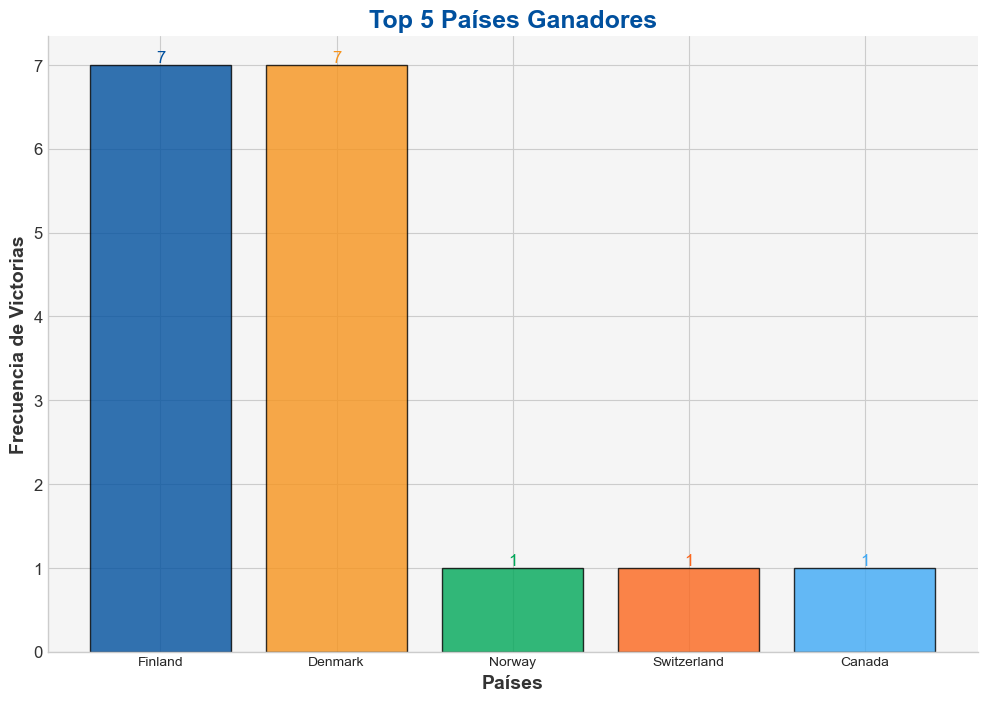

In [13]:
import matplotlib.pyplot as plt
import pandas as pd


df_result = ganadores_por_anio.select("Country name").groupBy("Country name").count().toPandas()

df_result = df_result.sort_values(by='count', ascending=False).head(5)

plt.style.use('seaborn-whitegrid')
plt.figure(figsize=(12, 8))

colors = ['#00509E', '#F7941D', '#00A859', '#FC671D', '#3FA9F5']

bars = plt.bar(df_result["Country name"], df_result["count"], color=colors, edgecolor='black', alpha=0.8)

# Añade etiquetas y título 
plt.xlabel('Países', fontsize=14, fontweight='bold', color='#333333', fontfamily='Arial')
plt.ylabel('Frecuencia de Victorias', fontsize=14, fontweight='bold', color='#333333', fontfamily='Arial')
plt.title('Top 5 Países Ganadores', fontsize=18, fontweight='bold', color='#00509E', fontfamily='Arial')

for bar, color in zip(bars, colors):
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, f'{yval}', ha='center', va='bottom', fontsize=12, color=color)

plt.legend(['Frecuencia'], loc='upper right', fontsize=12)

plt.gca().set_facecolor('#F5F5F5')

plt.gca().legend(frameon=False)

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

plt.yticks(fontsize=12, color='#333333', fontfamily='Arial')

plt.show()



## 4. ¿Qué puesto de Felicidad tiene el país con mayor GDP del 2020?

aqui tuve complicaciones por el tipo de dato al combinar las tablas es por ellos que se uso un cast as float en life ladder

In [83]:
from pyspark.sql.functions import col

data.createOrReplaceTempView("datos")

# Convertir la columna 'Log GDP per capita' a tipo numérico y obtener los primeros 5 países en 2020
query = """
    SELECT `Country name`, `year`, `Life Ladder`, `Log GDP per capita`,
           ROW_NUMBER() OVER (ORDER BY CAST(`Life Ladder` AS FLOAT) DESC) as life_ladder_rank
    FROM datos
    WHERE year = 2020
    ORDER BY CAST(`Log GDP per capita` AS FLOAT) DESC
    LIMIT 5
"""

result = spark.sql(query)

# Mostrar el resultado
result.show(truncate=False)

# Imprimir el mensaje 
if not result.isEmpty():
    country_name = result.select("Country name").first()[0]
    print(f"El país con el mayor Log GDP per capita en 2020 es: {country_name}")
    life_ladder_rank = result.select("life_ladder_rank").first()[0]
    print(f"Life Ladder Rank: {life_ladder_rank}")
else:
    print("No hay datos para mostrar.")


+--------------------+----+-----------+------------------+----------------+
|Country name        |year|Life Ladder|Log GDP per capita|life_ladder_rank|
+--------------------+----+-----------+------------------+----------------+
|Ireland             |2020|7.035      |11.323            |13              |
|Switzerland         |2020|7.508      |11.081            |4               |
|United Arab Emirates|2020|6.458      |11.053            |26              |
|Norway              |2020|7.290      |11.042            |8               |
|United States       |2020|7.028      |11.001            |14              |
+--------------------+----+-----------+------------------+----------------+

El país con el mayor Log GDP per capita en 2020 es: Ireland
Life Ladder Rank: 13


## 5. ¿En que porcentaje a variado a nivel mundial el GDP promedio del 2020 respecto al 2021? ¿Aumentó o disminuyó?

In [84]:
from pyspark.sql.functions import avg, col

data.createOrReplaceTempView("datos")

# Calcular el GDP promedio para el año 2020
gdp_2020 = spark.sql("""
    SELECT AVG(`Log GDP per capita`) as avg_gdp_2020
    FROM datos
    WHERE year = 2020
""").collect()[0]["avg_gdp_2020"]

# Calcular el GDP promedio para el año 2021
gdp_2021 = spark.sql("""
    SELECT AVG(`Log GDP per capita`) as avg_gdp_2021
    FROM datos
    WHERE year = 2021
""").collect()[0]["avg_gdp_2021"]

# Calcular la variación porcentual
percentage_change = ((gdp_2021 - gdp_2020) / gdp_2020) * 100

# Determinar si aumentó o disminuyó
change_status = "aumentó" if percentage_change > 0 else "disminuyó"

# Mostrar los resultados
print(f"El GDP promedio a nivel mundial en 2020 fue: {gdp_2020}")
print(f"El GDP promedio a nivel mundial en 2021 fue: {gdp_2021}")
print(f"La variación porcentual a nivel mundial del GDP promedio entre 2020 y 2021 fue del {percentage_change:.2f}% y {change_status}.")


El GDP promedio a nivel mundial en 2020 fue: 9.751329545454546
El GDP promedio a nivel mundial en 2021 fue: 9.432208053691273
La variación porcentual a nivel mundial del GDP promedio entre 2020 y 2021 fue del -3.27% y disminuyó.


## 6. ¿Cuál es el país con mayor expectativa de vide (“Healthy life expectancy at birth”)? Y ¿Cuánto tenia en ese indicador en el 2019?


In [107]:
from pyspark.sql.functions import col

# Asumiendo que 'data' es el DataFrame que contiene tus datos
data.createOrReplaceTempView("datos")

# Encontrar el país con la mayor expectativa de vida en 2021
max_life_expectancy_2021_query = """
    SELECT `Country name`, `year`, `Healthy life expectancy at birth` 
    FROM datos
    WHERE year = 2021
    ORDER BY `Healthy life expectancy at birth` DESC
    LIMIT 1
"""

max_life_expectancy_2021_result = spark.sql(max_life_expectancy_2021_query)

# Mostrar el resultado de 2021
max_life_expectancy_2021_result.show(truncate=False)

# Obtener la expectativa de vida en 2019 para el país encontrado en 2021
if not max_life_expectancy_2021_result.isEmpty():
    max_life_expectancy_country_name = max_life_expectancy_2021_result.select("Country name").first()[0]
    life_expectancy_2019_query = f"""
        SELECT `Country name`, `year`, `Healthy life expectancy at birth` 
        FROM datos
        WHERE `Country name` = '{max_life_expectancy_country_name}' AND year = 2019
    """
    life_expectancy_2019_result = spark.sql(life_expectancy_2019_query)
    
    # Mostrar el resultado de 2019 para el mismo país
    life_expectancy_2019_result.show(truncate=False)
else:
    print("No hay datos para mostrar.")



+------------+----+--------------------------------+
|Country name|year|Healthy life expectancy at birth|
+------------+----+--------------------------------+
|Singapore   |2021|76.953                          |
+------------+----+--------------------------------+

+------------+----+--------------------------------+
|Country name|year|Healthy life expectancy at birth|
+------------+----+--------------------------------+
|Singapore   |2019|77.100                          |
+------------+----+--------------------------------+

